In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vestiaire/vestiaire.csv


In [2]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

In [3]:
data0 = pd.read_csv("/kaggle/input/vestiaire/vestiaire.csv")

display(data0[0:2].T)  # Mostrar las primeras filas para revisar los datos

# Filtrar solo los productos que han sido vendidos
data0 = data0[data0['sold'] == True]

# Obtener el número de filas
n = len(data0)
print(n)

# Mezclar aleatoriamente los datos
N = list(range(n))
random.shuffle(N)

# Seleccionar una muestra aleatoria de 20,000 productos vendidos
data0 = data0.iloc[N[0:20000]]



,0,1
product_id,43247626,43247441
product_type,Wool mini skirt,Jacket
product_name,Wool mini skirt Miu Miu Grey size S Internatio...,Jacket Barbara Bui Navy size 42 FR in Cotton
product_description,Miu Miu – Pleated mini skirt Size: 36 (S) Wai...,For selling nice women's suit Barbara Bui size...
product_keywords,Miu Miu Wool Skirts,Barbara Bui Cotton Jackets
product_gender_target,Women,Women
product_category,Women Clothing,Women Clothing
product_season,Autumn / Winter,All seasons
product_condition,Never worn,Very good condition
product_like_count,34.0,1.0


13736


In [4]:
print(data0.columns.tolist())

['product_id', 'product_type', 'product_name', 'product_description', 'product_keywords', 'product_gender_target', 'product_category', 'product_season', 'product_condition', 'product_like_count', 'sold', 'reserved', 'available', 'in_stock', 'should_be_gone', 'brand_id', 'brand_name', 'brand_url', 'product_material', 'product_color', 'price_usd', 'seller_price', 'seller_earning', 'seller_badge', 'has_cross_border_fees', 'buyers_fees', 'warehouse_name', 'seller_id', 'seller_username', 'usually_ships_within', 'seller_country', 'seller_products_sold', 'seller_num_products_listed', 'seller_community_rank', 'seller_num_followers', 'seller_pass_rate']


In [5]:
#Ahora convertimos todas las columnas de tipo object (que generalmente corresponden a variables categóricas, como texto)
#en valores numéricos para que puedan ser utilizadas en modelos de machine learning.

from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [6]:
data1=labelencoder(data0.iloc[:,1:])

In [7]:
#TARGET SETTING

In [8]:
#Preparamos el dataset para el analisis, definimos el precio como variable objetivo

target=['price_usd']
dataY=data1[target]
dataX=data1.drop(target,axis=1)
df_columns = list(dataX.columns)
print(df_columns)

['product_type', 'product_name', 'product_description', 'product_keywords', 'product_gender_target', 'product_category', 'product_season', 'product_condition', 'product_like_count', 'sold', 'reserved', 'available', 'in_stock', 'should_be_gone', 'brand_id', 'brand_name', 'brand_url', 'product_material', 'product_color', 'seller_price', 'seller_earning', 'seller_badge', 'has_cross_border_fees', 'buyers_fees', 'warehouse_name', 'seller_id', 'seller_username', 'usually_ships_within', 'seller_country', 'seller_products_sold', 'seller_num_products_listed', 'seller_community_rank', 'seller_num_followers', 'seller_pass_rate']


In [9]:
#Separamos en entrenamiento y prueba

m=len(dataX)
print(m)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

trainX=dataX.iloc[M[0:(m//5)*4]]
trainY=dataY.iloc[M[0:(m//5)*4]]
testX=dataX.iloc[M[(m//5)*4:]]
testY=dataY.iloc[M[(m//5)*4:]]


13736


In [10]:
train_df=trainX
test_df=testX
train_df.columns=df_columns
test_df.columns=df_columns

def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

#Definición de una clase Timer para medir el tiempo de ejecución:

from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [11]:
#Creamos una función to_feature que aplica un conjunto de procesadores (en este caso, funciones que transforman los datos) a un DataFrame y mide el tiempo que tarda en hacerlo

from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [12]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 124.74it/s]


createcreate_numeric_feature  0.006[s]


100%|██████████| 1/1 [00:00<00:00, 199.75it/s]

createcreate_numeric_feature  0.003[s]


In [13]:
#MODELO

In [14]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)])

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Función para evaluar el modelo con métricas de regresión
def evaluate_model(y_true, y_pred):
    # Calcular MSE, RMSE, MAE y R²
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Mostrar las métricas
    print(f'MSE (Error cuadrático medio): {mse:.4f}')
    print(f'RMSE (Raíz del error cuadrático medio): {rmse:.4f}')
    print(f'MAE (Error absoluto medio): {mae:.4f}')
    print(f'R² (Coeficiente de determinación): {r2:.4f}')

In [15]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [16]:
y = trainY
ydf=pd.DataFrame(y)
ydf

,price_usd
25835,198.09
364436,153.93
395594,92.40
7134,53.77
196506,168.82
...,...
26604,59.72
687593,53.75
706760,228.76
328225,83.61


In [17]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4151
[LightGBM] [Info] Number of data points in the train set: 8790, number of used features: 30
[LightGBM] [Info] Start training from score 237.042405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,Nombre,Marca,Precio_real,Prediccion
6378,Camisole Moschino Cheap And Chic Turquoise siz...,Moschino Cheap And Chic,198.09,201.642451
658237,Track low trainers Balenciaga Green size 42 EU...,Balenciaga,153.93,139.868570
588467,Silk scarf Giorgio Passigatti Grey in Silk,Giorgio Passigatti,92.40,91.543355
777931,Tribute leather mules Saint Laurent Silver siz...,Saint Laurent,53.77,51.635607
709694,Leather flats Officine Creative Black size 43 ...,Officine Creative,168.82,159.432734
255210,Sweatshirt Polo Ralph Lauren Multicolour size ...,Polo Ralph Lauren,114.66,117.423695
104136,Wool blazer Saint Laurent Black size 40 FR in ...,Saint Laurent,42.17,5.221632
193258,Wool knitwear & sweatshirt Gucci Pink size S I...,Gucci,16.61,18.848472
849334,Leather heels Prada Black size 36.5 EU in Leat...,Prada,100.42,93.372535
861441,Leather flats Hermès Black size 38.5 EU in Lea...,Hermès,406.09,414.614543


<ipython-input-18-f1be3c03f517>:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


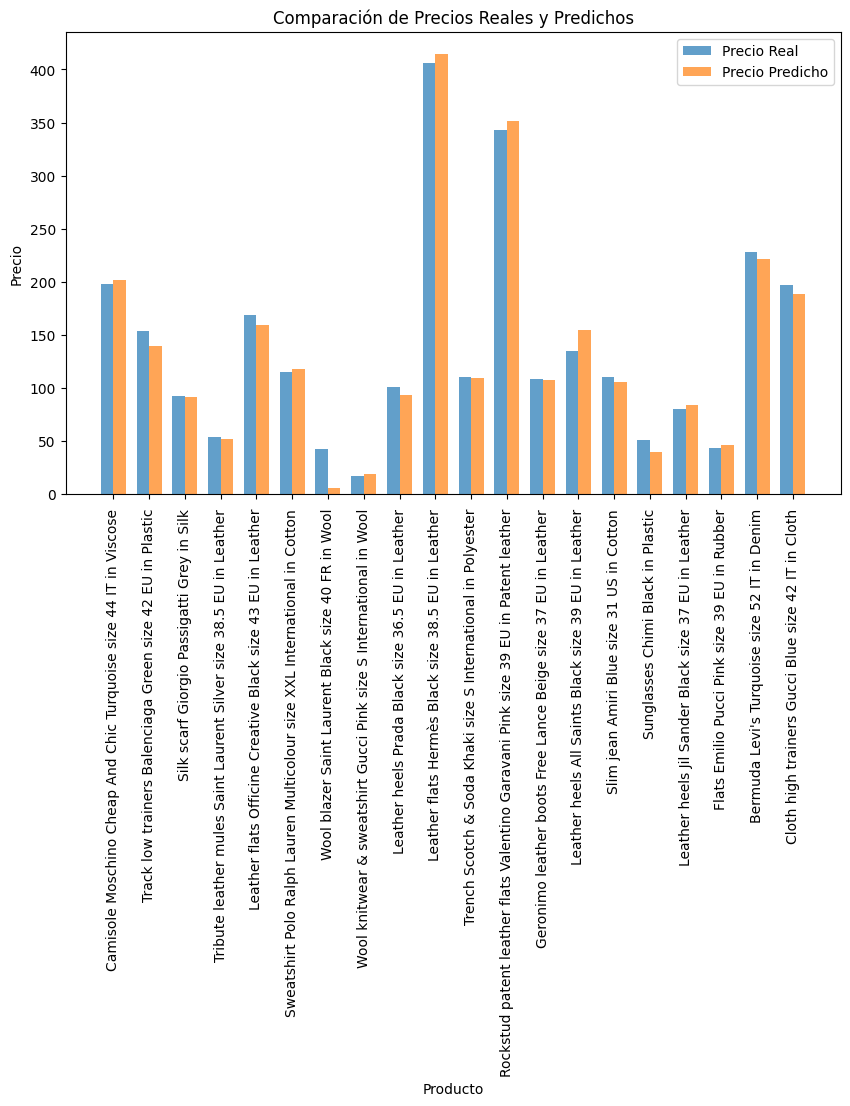

In [18]:
# Asegurémonos de que tenemos acceso a las predicciones 'oof' y los valores reales 'y'
# Seleccionamos los primeros 20 artículos para mostrar
top_20 = pd.DataFrame({
    'Nombre': data0['product_name'][:20],  # Aquí asumimos que 'name' es la columna de los nombres de los productos
    'Marca': data0['brand_name'][:20],
    'Precio_real': y[:20],
    'Prediccion': oof[:20]
})

# Mostrar la tabla con los precios reales, las predicciones y los nombres de los productos
import pandas as pd
display(top_20)

# Crear un gráfico de barras comparando el precio real y el precio predicho
plt.figure(figsize=(10,6))
bar_width = 0.35
index = range(len(top_20))

# Crear las barras para el precio real y el predicho
plt.bar(index, top_20['Precio_real'], bar_width, label='Precio Real', alpha=0.7)
plt.bar([i + bar_width for i in index], top_20['Prediccion'], bar_width, label='Precio Predicho', alpha=0.7)

# Añadir etiquetas y título
plt.xlabel('Producto')
plt.ylabel('Precio')
plt.title('Comparación de Precios Reales y Predichos')
plt.xticks([i + bar_width / 2 for i in index], top_20['Nombre'], rotation=90)  # Ajustar los nombres de productos en el eje x
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


NameError: name 'data0' is not defined